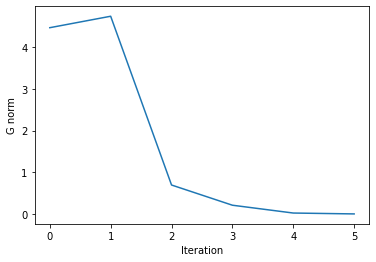

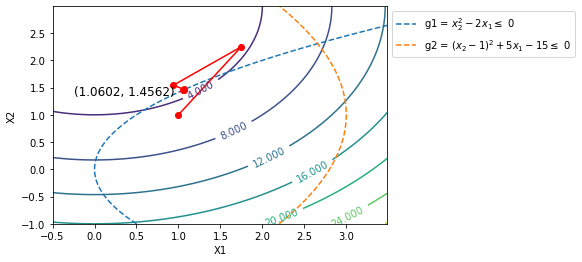

In [358]:
import torch as t
import math
import numpy as np
import matplotlib.pyplot as plt
import sys

# define problem:
def f(x):
    return t.tensor([[x[0]**2 + (x[1]-3)**2]])

def df(x):
    return t.tensor([[2*x[0],
                    2*(x[1]-3)]])

def g(x):
    return t.tensor([[x[1]**2-2*x[0],
                    (x[1]-1)**2+5*x[0]-15]])

def dg(x):
    return t.tensor([[-2,2*x[1]],
                    [5,2*(x[1]-1)]])

def solve_activeset(c,b,a,W):
    M_L = t.cat((W, a), 0)
    M_R = t.transpose(t.cat((a, t.zeros(a.size(dim=0),a.size(dim=0))), 1),0,1)
    M = t.cat((M_L, M_R), 1)
    U = t.transpose(t.cat((c, b), 1),0,1)
    sol = t.linalg.solve(M, U)

    S = sol[[0,1]]
    MU = sol[2:]
    return [S, MU]

def QP_solver(df0,g0,dg0):
    keepCal = True
    active = [] # [] for empty; [0] for g1; [1] for g2; [0,1] for g1 & g2
    i=0

    while keepCal:
        i = i+1

        mu0 = t.zeros(g0.size())
        g=g0[:,active]
        dg=dg0[active,:]

        [s, mu] = solve_activeset(-df0,-g,dg,H)

        n_digits = 12
        mu = (mu * 10**n_digits).round() / (10**n_digits)

        mu0[:,active]=t.transpose(mu,0,1)

        g_check = t.matmul(dg0,s)+t.transpose(g0,0,1)

        n_digits = 12
        g_check = (g_check * 10**n_digits).round() / (10**n_digits)

        mu_check = False

        if t.numel(mu)==0:
            mu_check = True
        elif t.min(mu)>0:
            mu_check = True
        else:
            remove=t.argmin(mu0).tolist()
            active.remove(remove)

        if t.max(g_check) <= 0:
            if mu_check:
                keepCal = False
        else:
            add=t.argmax(g_check).tolist()
            active.append(add)
        active = sorted(list(dict.fromkeys(active)))
        if i  > 50:
            sys.exit("QP solver too many iterations")
    return [s, mu0]

def line_search(F, dF, G, dG, x, s, mu_k, w_k):
    z = 0.1 # scale factor on current gradient: [0.01, 0.3]
    b = 0.8 # scale factor on backtracking: [0.1, 0.8]
    a = 1. # maximum step length

    D = t.squeeze(t.transpose(s,0,1)) # direction of search

    # merit function:
    w_k_1 = t.maximum(abs(mu_k), 0.5*(w_k+abs(mu_k)))

    count = 0
    while count<1000:

        phi_a = f(x+a*D) + t.matmul(w_k_1,t.transpose(t.maximum(t.zeros(g(x).size()),g(x+a*D)),0,1))

        phi0 = F + t.matmul(w_k_1,t.transpose(t.maximum(t.zeros(g(x).size()),G),0,1))

        dphi0 = t.matmul(dF,D) + t.matmul(w_k_1,t.transpose(((G>0)*1.)*t.matmul(dG,D),0,1))

        psi_a = phi0 + z*a*dphi0

        if phi_a<psi_a:
            break
        else:
            a = a*b
            count = count + 1

    return [a, w_k]

# Initialization:
x0 = t.tensor([1.,1.])
x_k = x0

# Initialization of the Hessian matrix
H = t.eye(t.numel(x_k))

# Initialization of the Lagrange multipliers
LM_k = t.zeros(g(x_k).size())   # Start with zero Lagrange multiplier estimates
# Initialization of the weights in merit function
w = t.zeros(g(x_k).size())   # Start with zero weights

# Set the termination criterion
opt_eps = 1e-5
G_norm = t.norm(df(x_k)+t.matmul(LM_k,dg(x_k)))

# Convergence list:
X1=[]
X2=[]
Obj = []

X1.append(x_k[0].item())
X2.append(x_k[1].item())
Obj.append(G_norm.item())

while G_norm>opt_eps:

    # solve QP
    [s_k, LM_k_1] = QP_solver(df(x_k),g(x_k),dg(x_k)) # return search direction (k) and new Lagrangian Multiplier(k+1)

    # LineSearch
    [a, w] = line_search(f(x_k), df(x_k), g(x_k), dg(x_k), x_k, s_k, LM_k, w)

    # Update the current solution using the step
    dx = t.transpose(a*s_k,0,1)  # Step for x

    x_k_1 = t.squeeze(x_k + dx)   # Update x using the step


    # Update Hessian using BFGS:

    # Compute y_k:
    y_k =df(x_k_1) + t.matmul(LM_k_1,dg(x_k_1)) - df(x_k) -  t.matmul(LM_k_1,dg(x_k))

    # Compute theta:
    Left = t.matmul(dx,t.transpose(y_k,0,1))
    Right = t.matmul(t.matmul(dx,H),t.transpose(dx,0,1))

    if Left >= 0.2*Right:
        theta = 1
    else:
        theta = 0.8*Right/(Right-Left)

    # Compute  dg_k:
    dg_k = theta*y_k + (1-theta)*t.matmul(dx,H)

    # Compute new Hessian:
    H = H + t.transpose(dg_k,0,1)*dg_k/t.sum(dg_k*dx) - t.transpose(t.matmul(dx,H),0,1)*t.matmul(dx,H)/Right

    # Update termination criterion:
    G_norm = t.norm(df(x_k_1)+t.matmul(LM_k_1,dg(x_k_1)))

    # Update x and lagrangian multipliers:
    x_k =x_k_1
    LM_k = LM_k_1

    # save x:
    X1.append(x_k[0].item())
    X2.append(x_k[1].item())
    Obj.append(G_norm.item())

# Convergence:
iteration = list(range(0,len(Obj)))
plt.plot(iteration,Obj)
plt.xlabel('Iteration')
plt.ylabel('G norm')
plt.show()

# Contour Line
delta = 0.01
x_1 = np.arange(-0.5, 3.5, delta)
x_2 = np.arange(-1.0, 3.0, delta)
x1, x2 = np.meshgrid(x_1, x_2)
y = x1**2 + (x2-3)**2

cp = plt.contour(x1, x2, y)
plt.clabel(cp, inline=1, fontsize=10)
plt.xlabel('X1')
plt.ylabel('X2')

# Boundaries
plt.plot(x_2**2/2, x_2,'--',label='g1 = $x_2^2-2x_1 \leq$ 0')
plt.plot(3-(x_2-1)**2/5, x_2,'--', label='g2 = $(x_2-1)^2+5x_1-15 \leq$ 0')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

# Convergence on Contour Plot
plt.plot(X1,X2, 'o-r')
# Solution text with position offset
plt.text(X1[-1]-1.3, X2[-1]-0.1, "(%.4f, %.4f)" % (X1[-1], X2[-1]), fontsize=12)

plt.xlim([x_1.min(), x_1.max()])
plt.ylim([x_2.min(), x_2.max()])
plt.show()

In [330]:
# Verify
from scipy.optimize import minimize
fun = lambda x: x[0]**2 + (x[1]-3)**2

cons = ({'type': 'ineq', 'fun': lambda x:  2*x[0]-x[1]**2},
        {'type': 'ineq', 'fun': lambda x:  15-(x[1]-1)**2-5*x[0]})

x0 = [1,1]
res = minimize(fun, x0, method='SLSQP',
               constraints=cons)
print(res)


     fun: 3.507468048250421
     jac: array([ 2.12041229, -3.08767256])
 message: 'Optimization terminated successfully'
    nfev: 17
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([1.06020715, 1.45616424])
